# Analysis: Piece Counts by Theme

Goal: Run ANOVA and welch tests to investigate if average number of pieces are different by theme.   

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
%load_ext autoreload
%autoreload 2         # reload custom py file eveytime a new cell is run

import brickset_helper as bh

## Import Data

In [4]:
SET_FILE = 'data/brickset_set_clean.csv'

In [5]:
set_df = pd.read_csv(SET_FILE)
set_df = set_df[['set_no', 'name', 'theme_group', 'theme', 'subtheme', 'year', 'piece_cnt', 'minifig_cnt', 
                'tags', 'set_type', 'packaging']]
set_df.head()
set_df.info()

,set_no,name,theme_group,theme,subtheme,year,piece_cnt,minifig_cnt,tags,set_type,packaging
0,722-1,"Universal Building Set, 7+",Basic,Basic,NaN,1980.0,301.0,0.0,"4X4, Aircraft, Articulated Lorry, Boat, Car, C...",Normal,NaN
1,733-1,"Universal Building Set, 7+",Basic,Basic,NaN,1980.0,533.0,0.0,"Articulated Lorry, Base, Baseplate, Crane, For...",Normal,NaN
2,744-1,"Universal Building Set with Motor, 7+",Basic,Basic,NaN,1980.0,537.0,0.0,"8 Wheel Vehicle, Crane, Electric Motor, Mobile...",Normal,NaN
3,820-1,Red Plates Parts Pack,Basic,Basic,Supplementaries,1980.0,34.0,0.0,NaN,Normal,NaN
4,822-1,Blue Plates Parts Pack,Basic,Basic,Supplementaries,1980.0,34.0,0.0,NaN,Normal,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13754 entries, 0 to 13753
Data columns (total 11 columns):
set_no         13754 non-null object
name           13754 non-null object
theme_group    13754 non-null object
theme          13754 non-null object
subtheme       10040 non-null object
year           13754 non-null float64
piece_cnt      10858 non-null float64
minifig_cnt    13754 non-null float64
tags           10265 non-null object
set_type       13753 non-null object
packaging      8919 non-null object
dtypes: float64(3), object(8)
memory usage: 1.2+ MB


## Filter based on each column of interest

In [6]:
# filter in bulk by group theme

remove_group_ls = ['Basic', 'Constraction', 'Educational', 'Girls', 'Miscellaneous', 'Pre-school', 
                   'Technical', 'Vintage themes']
set_df = set_df.loc[set_df['theme_group'].isin(remove_group_ls)==False]
set_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5610 entries, 43 to 13751
Data columns (total 11 columns):
set_no         5610 non-null object
name           5610 non-null object
theme_group    5610 non-null object
theme          5610 non-null object
subtheme       4617 non-null object
year           5610 non-null float64
piece_cnt      5404 non-null float64
minifig_cnt    5610 non-null float64
tags           5276 non-null object
set_type       5610 non-null object
packaging      5181 non-null object
dtypes: float64(3), object(8)
memory usage: 525.9+ KB


In [7]:
set_df['category'] = set_df['theme'].apply(bh.get_category)
set_df['category'].value_counts()

Exclude-No-Minifigs    1100
Licensed-Movie          848
Lego-Block              780
Town                    662
City                    585
Exclude                 417
Licensed-Other          332
Space                   294
Castle                  277
Historic                173
None                    142
Name: category, dtype: int64

In [8]:
set_df.loc[set_df['category']=='None']['theme'].value_counts()

Dinosaurs                            12
Boats                                12
Spider-Man                           11
Time Cruisers                         9
Pharaoh's Quest                       9
World Racers                          9
The Lone Ranger                       8
Vikings                               7
Aqua Raiders                          7
Dino                                  7
Scooby-Doo                            7
The Angry Birds Movie                 6
Prince of Persia                      6
Discovery                             6
Dino Attack                           6
Mickey Mouse                          5
Dino 2010                             5
The Simpsons                          2
Ghostbusters                          2
The Powerpuff Girls                   2
Avatar The Last Airbender             2
Overwatch                             1
The Lego Movie 2: The Second Part     1
Name: theme, dtype: int64

In [9]:
# filter out themes that are excluded

set_df = set_df.loc[set_df['category'].isin(['Exclude', 'Exclude-No-Minifigs', 'None'])==False]
set_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3951 entries, 43 to 13749
Data columns (total 12 columns):
set_no         3951 non-null object
name           3951 non-null object
theme_group    3951 non-null object
theme          3951 non-null object
subtheme       3589 non-null object
year           3951 non-null float64
piece_cnt      3774 non-null float64
minifig_cnt    3951 non-null float64
tags           3763 non-null object
set_type       3951 non-null object
packaging      3737 non-null object
category       3951 non-null object
dtypes: float64(3), object(9)
memory usage: 401.3+ KB


In [10]:
set_df['category'].value_counts()

Licensed-Movie    848
Lego-Block        780
Town              662
City              585
Licensed-Other    332
Space             294
Castle            277
Historic          173
Name: category, dtype: int64

In [11]:
# keep only sets with valid piece count

set_df = set_df.loc[set_df['piece_cnt'] >= 1]
set_df.shape

(3774, 12)

In [12]:
# keep only the normal set types

set_df = set_df.loc[set_df['set_type']=='Normal']
set_df.shape

(3315, 12)

In [13]:
# keep only the normal set types

set_df = set_df.loc[set_df['packaging']=='Box']
set_df.shape

(2700, 12)

In [14]:
set_df['category'].value_counts()

Licensed-Movie    563
Town              538
Lego-Block        421
City              396
Licensed-Other    230
Space             219
Castle            186
Historic          147
Name: category, dtype: int64

In [51]:
# do final column re-arrangement

set_clean_df = set_df[['set_no', 'name', 'category', 'theme', 'year', 'piece_cnt', 'minifig_cnt']]
set_clean_df = set_clean_df.reset_index().drop(columns=['index'])
set_clean_df.head()

,set_no,name,category,theme,year,piece_cnt,minifig_cnt
0,1591-1,Danone Delivery Truck,Town,Town,1980.0,40.0,0.0
1,1592-1,Town Square - Castle Scene,Town,Town,1980.0,471.0,11.0
2,1651-2,Maersk Line Container Lorry,Town,Town,1980.0,305.0,1.0
3,6305-1,Trees and Flowers,Town,Town,1980.0,12.0,0.0
4,6306-1,Road Signs,Town,Town,1980.0,12.0,0.0


## Run Analysis

[Text(0, 0.5, 'Number of Sets'),
 (0, 1000),
 Text(0.5, 0, 'Number of Pieces'),
 Text(0.5, 1.0, 'Population Number of Pieces Distribution')]

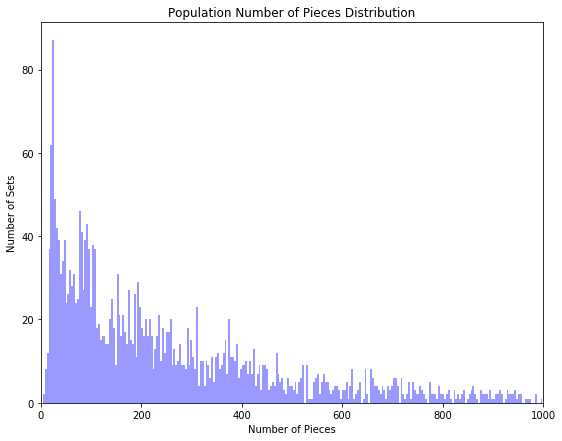

In [52]:
fig, axs = plt.subplots(1,1, figsize=(9, 7))

sns.distplot(set_clean_df['piece_cnt'], ax=axs, bins=2000, kde=False, color='#0000ff')
axs.set(title='Population Number of Pieces Distribution', xlabel='Number of Pieces', 
        ylabel='Number of Sets', xlim=[0, 1000])

In [57]:
#list(set_clean_df.loc[set_clean_df['category']==c, 'piece_cnt'] for c in set_clean_df['category'].unique())

In [27]:
# anova test is meaningless since normality assumption is violated

stats.f_oneway( *(set_clean_df.loc[set_clean_df['category']==c, 'piece_cnt'] 
                  for c in set_clean_df['category'].unique()) )

F_onewayResult(statistic=41.39868280806258, pvalue=1.0321030361836583e-55)

In [92]:
# samples are not normally distributed, can't run welch test

size_sr = set_clean_df.groupby('category').count()['piece_cnt']
median_sr = set_clean_df.groupby('category').quantile(0.5)['piece_cnt']
mode_sr = set_clean_df.groupby('category')['piece_cnt'].apply(lambda x: x.mode())

size_sr
median_sr
mode_sr

category
Castle            186
City              396
Historic          147
Lego-Block        421
Licensed-Movie    563
Licensed-Other    230
Space             219
Town              538
Name: piece_cnt, dtype: int64

category
Castle            107.5
City              232.0
Historic           88.0
Lego-Block        258.0
Licensed-Movie    305.0
Licensed-Other    276.0
Space             105.0
Town               81.0
Name: piece_cnt, dtype: float64

category         
Castle          0     21.0
City            0    151.0
Historic        0     21.0
Lego-Block      0     92.0
Licensed-Movie  0     82.0
Licensed-Other  0     79.0
Space           0     23.0
Town            0     23.0
Name: piece_cnt, dtype: float64

In [ ]:
stats.ttest_ind(region_MW_sr, region_NE_sr)

## Export to csv

In [18]:
save_path = r'data/brickset_anova.csv'
#set_df.to_csv(save_path, index=False)
f'{round(os.path.getsize(save_path) /1e6, 2)} mb'

'0.17 mb'